# Model evaluation

- In this section we will evaluate all the 5 models to find which one is the best for binary classification
- We will boil down to how the model is able to detect the positives and the negatives minimizing false positives and false negatives.

c:\Users\Johny\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:23:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Logistic Regression,0.846831,0.846975,0.997904,0.916266,0.848435
Random Forest,0.882042,0.879630,0.995807,0.934120,0.785265
Gradient Boosting,0.860915,0.864469,0.989518,0.922776,0.777858
Linear SVM,0.876761,0.887619,0.976939,0.930140,0.851199
XGBoost,0.866197,0.874766,0.981132,0.924901,0.778573


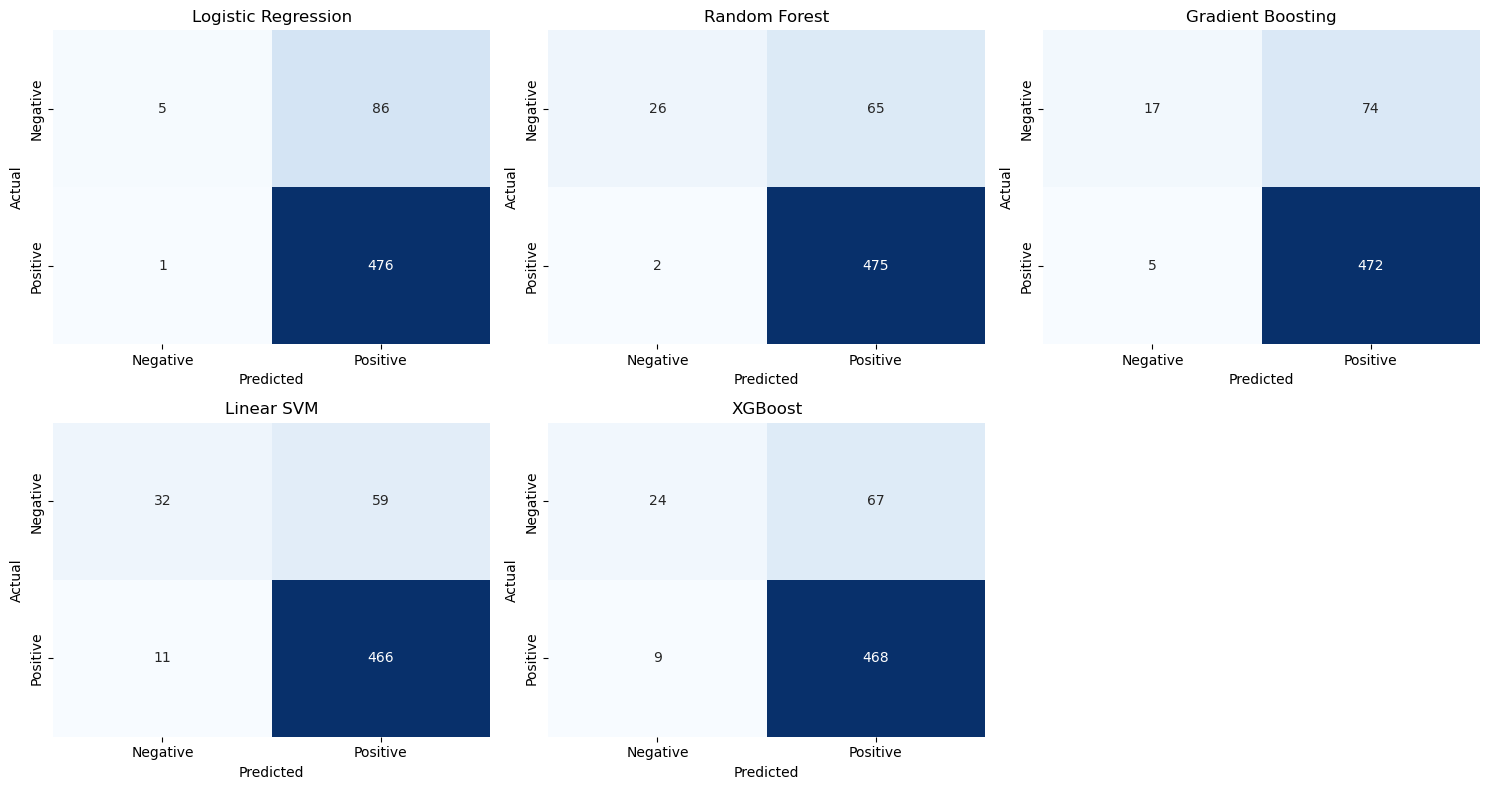

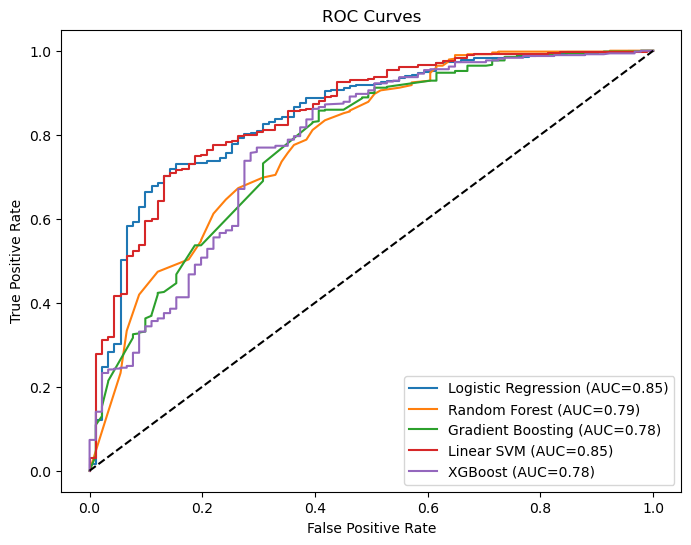

In [12]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Linear SVM": LinearSVC(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
}

# --------------------------
# We will store the results here
# --------------------------
results = {}
conf_matrices = {}
roc_data = {}

# --------------------------
# Single evaluation loop with the validation set
# --------------------------
for name, model in models.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", model)
    ])

    # Train
    pipe.fit(Xb_temp, yb_temp)

    # Predictions
    y_pred = pipe.predict(Xb_val)

    # Probas for ROC
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_proba = pipe.predict_proba(Xb_val)[:, 1]
    elif hasattr(pipe.named_steps["clf"], "decision_function"):
        y_proba = pipe.decision_function(Xb_val)
    else:
        y_proba = None

    # Metrics
    report = classification_report(yb_val, y_pred, output_dict=True)
    acc = accuracy_score(yb_val, y_pred)
    auc = roc_auc_score(yb_val, y_proba) if y_proba is not None else None

    results[name] = {
        "Accuracy": acc,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": auc
    }

    # Confusion matrix
    conf_matrices[name] = confusion_matrix(yb_val, y_pred)

    # ROC data
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(yb_val, y_proba)
        roc_data[name] = (fpr, tpr, auc)

# --------------------------
# Results Table
# --------------------------
results_df = pd.DataFrame(results).T
display(results_df)

# --------------------------
# Confusion Matrices Heatmaps
# --------------------------
n_models = len(conf_matrices)
cols = 3
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

for ax, (name, cm) in zip(axes.flatten(), conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"], ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Remove unused subplots
for ax in axes.flatten()[len(conf_matrices):]:
    ax.remove()

plt.tight_layout()
plt.show()

# --------------------------
# ROC Curves
# --------------------------
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

## 📊 Model Evaluation Results

| Model                | Accuracy | Precision | Recall  | F1-Score | ROC-AUC |
|-----------------------|----------|-----------|---------|----------|---------|
| Logistic Regression   | **0.847** | 0.847     | **0.998** | 0.916    | 0.848   |
| Random Forest         | **0.882** | 0.880     | **0.996** | **0.934** | 0.785   |
| Gradient Boosting     | 0.861    | 0.864     | 0.990   | 0.923    | 0.778   |
| Linear SVM            | 0.877    | **0.888** | 0.977   | 0.930    | **0.851** |
| XGBoost               | 0.866    | 0.875     | 0.981   | 0.925    | 0.779   |




Analysis of Model Performance Metrics
This table compares five different machine learning models across five key evaluation metrics. The high Recall scores across all models suggest the dataset might have a class imbalance, meaning one class (likely the positive class) has significantly more examples than the other.

Here is a breakdown of each model's performance:

Logistic Regression: Shows solid and balanced performance across all metrics. Its high Recall (0.998) means it is excellent at identifying positive cases, but its Precision (0.847) is lower than others, indicating it has more false positives. Its ROC-AUC is strong, confirming good overall separability.

Random Forest: This is the top-performing model in terms of overall accuracy (0.882) and F1-score (0.934). It achieves the best balance between Precision and Recall. However, its ROC-AUC score (0.785) is surprisingly the lowest, which can sometimes happen with imbalanced data and might warrant a closer look at the probability calibrations.

Gradient Boosting & XGBoost: These two boosting algorithms perform very similarly. They have good but not top-tier Accuracy and F1-scores. Their key weakness is a relatively low ROC-AUC, similar to Random Forest, suggesting their ability to distinguish between classes is less robust than Logistic Regression or SVM.

Linear SVM: Demonstrates very strong performance, boasting the highest Precision (0.888) and a very high F1-score (0.930). This means when it predicts a positive, it is most likely to be correct. Its high ROC-AUC score is second only to Logistic Regression, indicating excellent model confidence.

Summary and Recommendation
Best Overall Model: Random Forest, due to its highest Accuracy and F1-score, which best balances the trade-off between false positives and false negatives.

Best for High-Certainty Predictions: Linear SVM, if your priority is minimizing false positives (i.e., you want to be very sure a prediction is positive when you make it).

Key Observation: All models have exceptionally high Recall (>0.97). This means they are all very good at capturing nearly all positive instances in the data. The primary differences between them lie in how many false positives they generate (reflected in Precision).